# Pytorch Tensorboard

* [PyTorch - Visualizing Models, Data, and Training with TensorBoard](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)
* [how-to-use-tensorboard-with-pytorch](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-tensorboard-with-pytorch.md)
* [Pytorch TensorBoard Tutorial](https://www.youtube.com/watch?v=RLqsxWaQdHE)
* [Using Tensorboard in Pytorch](https://krishansubudhi.github.io/deeplearning/2020/03/24/tensorboard-pytorch.html)
* [PyTorch Profiler With TensorBoard](https://pytorch.org/tutorials/intermediate/tensorboard_profiler_tutorial.html)

> In this tutorial, we will use a simple Resnet model to demonstrate how to use TensorBoard plugin to analyze model performance. Profiler API is capable of recording the CPU side operations as well as the CUDA kernel launches on the GPU side. The profiler can visualize this information in TensorBoard Plugin and provide analysis of the performance bottlenecks.

## Training examples

[Training with PyTorch](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html)

> For this tutorial, we’ll be using the Fashion-MNIST dataset provided by TorchVision. We use torchvision.transforms.Normalize() to zero-center and normalize the distribution of the image tile content, and download both training and validation data splits.

* [Kaggle - Fashion MNIST with Pytorch](https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
import sys
sys.path.append(f'/content/gdrive/MyDrive/home/repository/git/oonisim/lib/code/python')

In [52]:
import os
import sys
from itertools import (
    product
)
from typing import (
    List,
    Union,
)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix
)
import torch
from torch import nn
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.tensorboard import (
    SummaryWriter,
)
# https://discuss.pytorch.org/t/error-while-multiprocessing-in-dataloader/46845/19
from tqdm import tqdm

In [6]:
%load_ext tensorboard

In [37]:
%load_ext autoreload
%autoreload 2
from lib.util_torch import (    # PYTHONPATH points to the library parent.
    get_image_data_mean_std,
    get_accuracy_multi_labels,
    tensorboard_write_histogram,
    tensorboard_write_graph,
    tensorboard_write_image,
    tensorboard_write_scalar,
    tensorboard_write_scalars,
    plot_confusion_matrix,
    tensorboard_write_confusion_matrix,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

## Train & Validation Dataset

### Calculate the mean and std of the pixels (features) per each channel

In [ ]:
dataset_train = FashionMNIST(
    os.getcwd(),
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)
mean, std = get_image_data_mean_std(
    loader=torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=16)
)

### Normalize the image pixels (features)

In [57]:
dataset_train = FashionMNIST(
    os.getcwd(),
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
)

### Verify the std/mean of normalized

In [ ]:
mean, std = get_image_data_mean_std(
    loader=torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=16)
)
print(f"(mean, std)={mean, std}")

### Data loaders

In [61]:
train_size = int(0.8 * len(dataset_train))
val_size = len(dataset_train) - train_size
training_data, val_data = torch.utils.data.random_split(dataset_train, [train_size, val_size])

# train_loader = torch.utils.data.DataLoader(training_data, batch_size=8, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=val_size,  shuffle=True, num_workers=0)

## Test Dataset

### Data Loader

In [62]:
dataset_test = FashionMNIST(
    os.getcwd(),
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
)
test_size: int = len(dataset_test)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=test_size, shuffle=True, num_workers=0)

## Labels

In [63]:
id_to_label = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
list(id_to_label.values())

['T-Shirt',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle Boot']

In [64]:
id_to_label.get(0)

'T-Shirt'

## Sample image

In [65]:
X, Y = next(iter(val_loader))
x = X[0]
y = Y[0]

channels: int = x.shape[0]
width: int = x.shape[1]
height: int = x.shape[2]
(channels, width, height)

(1, 28, 28)

Pullover


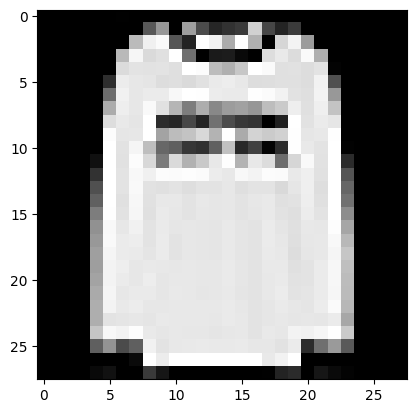

In [66]:
print(id_to_label.get(y.item()))
plt.imshow(x.squeeze(), cmap="gray")

---

# Model

In [67]:
class ConvNet(nn.Module):
  '''
    Simple Convolutional Neural Network
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Conv2d(channels, 16, kernel_size=3, padding="same"),
      nn.BatchNorm2d(16),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(),
      nn.Conv2d(16, 32, kernel_size=3, padding="same"),
      nn.BatchNorm2d(32),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(),
      nn.Flatten(),
      nn.Dropout(p=0.2, inplace=False),
      nn.Linear(width * height * 32 // 16, 64),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

In [68]:
ConvNet()

ConvNet(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Dropout(p=0.2, inplace=False)
    (10): Linear(in_features=1568, out_features=64, bias=True)
    (11): Linear(in_features=64, out_features=32, bias=True)
    (12): ReLU()
    (13): Linear(in_features=32, out_features=10, bias=True)
  )
)

---
# Tensorboard

## Model Grapph

In [69]:
# tensorboard_write_graph(writer=writer, model=ConvNet(), x=X)

# Hyper Parameters

In [70]:
batch_sizes: List[int] = [
    8, 16, 32, 64
]
learning_rates: List[float] = [
    1e-3, 1e-4, 1e-5
]
beta1s: List[float] = [
    0.85, 0.9, 0.95
]
beta2s: List[float] = [
    0.9985, 0.999, 0.9995
]
decays: List[float] = [
    0.005, 0.01, 0.015
]

# Training Loop

## Set Device

In [71]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


## Run training

In [ ]:
%rm -rf ./logs
# writer = SummaryWriter("./logs")

In [ ]:
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
NUM_EPOCHS: int = 4

In [ ]:
max_test_acc: float = 0.0
writer = None

for batch_size, lr, beta1, beta2, decay in product(batch_sizes, learning_rates, beta1s, beta2s, decays):
    run_name: str = f"./logs/batch{batch_size}_lr{lr}_beta1{beta1}_beta2{beta2}_decay{decay}"

    print()
    print('-' * 80)
    print(f"batch_size:{batch_size} lr:{lr} beta1:{beta1} beta2:{beta2} decay:{decay}")
    print('-' * 80)

    # --------------------------------------------------------------------------------
    # Initialize at new parameter combination.
    # --------------------------------------------------------------------------------
    prev_loss: float = float(sys.maxsize)
    early_stop_tolerance: int = 3

    if isinstance(writer, SummaryWriter):
        writer.close()

    writer = SummaryWriter(run_name)

    # num_workers=0 to avoid the issue in https://discuss.pytorch.org/t/error-while-multiprocessing-in-dataloader/46845/19
    train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=0)
    model: nn.Module = ConvNet()
    model = model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=decay)
    loss_fn = nn.CrossEntropyLoss(reduction='mean')   # normalized by batch size

    # --------------------------------------------------------------------------------
    # Train for each parameter combination.
    # --------------------------------------------------------------------------------
    for epoch in range(0, NUM_EPOCHS):
        print(f'Starting epoch:[{epoch}].')
        tensorboard_write_histogram(writer=writer, model=model, step=epoch)


        _cumulative_loss: float = 0.0    # Reset cumulative training loss during an epoch
        _train_loss: float = 0.0         # Reset training loss during an epoch
        model.train(True)
        for index, data in enumerate(train_loader, 0):
            inputs, labels = data
            _batch_size: int = len(inputs)

            # Write an image at every batch 0
            if index == 0:
                tensorboard_write_image(
                    writer=writer, tag="image", image=inputs[0], step=epoch, dataformats="CHW"
                )

            # Zero the gradients
            optimizer.zero_grad()

            # Perform forward pass
            outputs = model(inputs.to(device))

            # Compute loss
            loss = loss_fn(outputs, labels.to(device))

            # Perform backward pass
            loss.backward()

            # Perform optimization
            optimizer.step()

            # Print statistics
            _cumulative_loss += loss.item()
            _train_loss = _cumulative_loss / (index + 1)

            if index % 1000 == 0:
                print(f'training loss at batch:[{index:05d}]: {_train_loss:.03f}')

            # if index > 209: break

        # --------------------------------------------------------------------------------
        # Reports per epoch
        # --------------------------------------------------------------------------------
        model.eval()

        # Accuracy & confusion matrix
        inputs = labels = predictions = None
        with torch.no_grad():
            inputs, labels = next(iter(val_loader))

            predictions = model(inputs.to(device))
            val_loss = loss_fn(predictions, labels.to(device))

        val_acc = get_accuracy_multi_labels(predictions=predictions.cpu(), labels=labels)

        # Loss
        tensorboard_write_scalars(
            writer=writer,
            tag="loss",
            tag_scalar_dict={
                "training" : _train_loss,
                "validation" : val_loss
            },
            step=epoch
        )
        tensorboard_write_scalar(
            writer=writer, tag="validation accuracy/epoch", value=val_acc, step=epoch
        )
        tensorboard_write_confusion_matrix(
            writer=writer,
            tag="validation confusion matrix",
            predictions=torch.argmax(predictions.cpu(), axis=-1),
            truth=labels,
            class_names=list(id_to_label.values()),
            step=epoch
        )
        print(f'val_acc {val_acc:.03f} val_loss {val_loss: .03f}')
        writer.flush()

        # --------------------------------------------------------------------------------
        # Early stop
        # --------------------------------------------------------------------------------
        if val_loss > prev_loss:
            early_stop_tolerance -= 1
        else:
            prev_loss = val_loss

        if early_stop_tolerance <= 0:
            print("early stop")
            break

    # --------------------------------------------------------------------------------
    # Test
    # --------------------------------------------------------------------------------
    inputs = labels = predictions = None
    model.eval()
    with torch.no_grad():
        inputs, labels = next(iter(test_loader))
        predictions = model(inputs.to(device))

    test_loss = loss_fn(predictions, labels.to(device))
    test_acc = get_accuracy_multi_labels(predictions=predictions.cpu(), labels=labels)
    print(f'test_acc {test_acc:.03f} test_loss {test_loss: .03f}')

    # Report test results
    tensorboard_write_scalar(
        writer=writer, tag="loss", value=test_loss, step=epoch
    )
    tensorboard_write_scalar(
        writer=writer, tag="accuracy", value=test_acc, step=epoch
    )
    tensorboard_write_confusion_matrix(
        writer=writer,
        tag="test confusion matrix",
        predictions=torch.argmax(predictions.cpu(), axis=-1),
        truth=labels,
        class_names=list(id_to_label.values()),
        step=epoch
    )
    writer.add_hparams(
        hparam_dict={"batch": batch_size, "lr": lr, "beta1": beta1, "beta2": beta2, "decay": decay},
        metric_dict={
            "test_accuracy": test_acc,
            "test_loss": test_loss,
        },
        run_name=run_name,
    )
    writer.flush()

    # Save model if the accuracy is better
    if max_test_acc < test_acc:
        print()
        print(f"max test accuracy:[{test_acc}] with batch:{batch_size} lr:{lr} beta1:{beta1} beta2:{beta2} decay:{decay}")
        max_test_acc = test_acc

        print(f"saving the model as model.pth...")
        torch.save(model, 'model.pth')


# Process is complete.
print('Training process has finished.')


--------------------------------------------------------------------------------
batch_size:128 lr:0.001 beta1:0.85 beta2:0.9985 decay:0.005
--------------------------------------------------------------------------------
Starting epoch:[0].
training loss at batch:[00000]: 2.287


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7d218b5cd5d0>


val_acc 0.873 val_loss  0.354
Starting epoch:[1].
training loss at batch:[00000]: 0.404


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7d218b383fa0>


val_acc 0.899 val_loss  0.281
Starting epoch:[2].
training loss at batch:[00000]: 0.379


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7d21867193c0>


val_acc 0.895 val_loss  0.285
Starting epoch:[3].
training loss at batch:[00000]: 0.282


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7d2188c42770>


val_acc 0.900 val_loss  0.279


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7d2184b1fa00>


test_acc 0.276 test_loss  2.803

max test accuracy:[0.2757] with batch:128 lr:0.001 beta1:0.85 beta2:0.9985 decay:0.005
saving the model as model.pth...

--------------------------------------------------------------------------------
batch_size:128 lr:0.001 beta1:0.85 beta2:0.9985 decay:0.01
--------------------------------------------------------------------------------
Starting epoch:[0].
training loss at batch:[00000]: 2.318


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7d2188d89360>


val_acc 0.883 val_loss  0.326
Starting epoch:[1].
training loss at batch:[00000]: 0.292


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7d21843a5a50>


val_acc 0.894 val_loss  0.295
Starting epoch:[2].
training loss at batch:[00000]: 0.261


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7d21dd8973d0>


val_acc 0.898 val_loss  0.285
Starting epoch:[3].
training loss at batch:[00000]: 0.394


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7d21862118a0>


val_acc 0.906 val_loss  0.258


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7d2186c605b0>


test_acc 0.230 test_loss  2.165

--------------------------------------------------------------------------------
batch_size:128 lr:0.001 beta1:0.85 beta2:0.9985 decay:0.015
--------------------------------------------------------------------------------
Starting epoch:[0].
training loss at batch:[00000]: 2.313


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7d21869c09a0>


val_acc 0.878 val_loss  0.338
Starting epoch:[1].
training loss at batch:[00000]: 0.276


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7d21de7580a0>


val_acc 0.899 val_loss  0.285
Starting epoch:[2].
training loss at batch:[00000]: 0.226


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7d2189abbfd0>


val_acc 0.900 val_loss  0.278
Starting epoch:[3].
training loss at batch:[00000]: 0.357


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7d21de895060>


val_acc 0.900 val_loss  0.275


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7d2189445300>


test_acc 0.250 test_loss  3.270

--------------------------------------------------------------------------------
batch_size:128 lr:0.001 beta1:0.85 beta2:0.999 decay:0.005
--------------------------------------------------------------------------------
Starting epoch:[0].
training loss at batch:[00000]: 2.320


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7d22432e3e20>


val_acc 0.884 val_loss  0.332
Starting epoch:[1].
training loss at batch:[00000]: 0.286


# Confusion Matrix

In [ ]:
with torch.no_grad():
    inputs, labels = next(iter(test_loader))
    predictions = model(inputs)

In [ ]:
labels = labels.numpy()
predictions = np.argmax(predictions.numpy(), axis=-1).squeeze()

In [ ]:
tensorboard_write_confusion_matrix(
    writer=writer,
    tag="confusion matrix",
    predictions=predictions,
    truth=labels,
    class_names=list(id_to_label.values()),
    step=1
)

# Tensorboard

In [ ]:
%tensorboard --logdir ./logs/

# Cleanup

In [ ]:
writer.close()

In [ ]:
from google.colab import runtime
runtime.unassign()